# **1. Requrired libraries and parameters**

In [1]:
#  required lib for colorful plot 
! pip install colorama
import colorama
from colorama import Fore

✅ **This code needs utils.py file  to be executed**
 

---



---



---




✅ **Enable GPU**

---



---



---



---



In [2]:
#!!!!!!!!!!!!!
  # If GPU is not activated, The following code will return an error 
# !!!!!!!!!!!!
import nvidia_smi
nvidia_smi.nvmlInit()
deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print(Fore.RED+"Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))


Device 0: b'Tesla K80', Memory : (100.00% free): 11996954624(total), 11996954624 (free), 0 (used)


In [3]:
import keras
import numpy as np
import time
import os
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import utils
from tensorflow.keras import backend as k
import keras.backend
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Input, Add, Dense, Dropout, Flatten
from keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers 
from tensorflow.keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import gc
from tensorflow.keras.callbacks import Callback
from keras.utils.vis_utils import plot_model
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [4]:
# fixed parameters
output_dim = 10 
dataset = 'cidar'
input_width =32
input_height = 32
input_channels = 3
results_path = "./results/" + dataset + "/"
if not os.path.exists(results_path):
        os.makedirs(results_path)
        
# run parameteres
number_runs = 1
number_iterations =10
population_size = 20
batch_size_pso =    128
psofit_steps=15
psoeval_steps=5
batch_size_full_training = 128
epochs_pso = 1
epochs_full_training = 10
dropout = 0.3
dropout_pso=0.3

#  CNN parameters
max_conv_output_channels = 200
max_fully_connected_neurons = 500
min_layer =10
max_layer = 18
probability_convolution = 0.4
probability_pooling = 0.3
probability_fully_connected = 0.3
max_conv_kernel_size = 5

# 
Cg = 0.3
all_gBest_metrics = np.zeros((number_runs, 2))
runs_time = []
all_gbest_par = []
best_gBest_acc = 0

#  specify a path to save final model 
path = F"/content/gdrive/My Drive/14far/final2/model70" 

# **2. Loading dataset**

In [5]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test)  = cifar10.load_data()
y_train = keras.utils.np_utils.to_categorical(y_train, output_dim)
y_test = keras.utils.np_utils.to_categorical(y_test, output_dim)
x_train.shape

170508288/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [6]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.02)

data_test = ImageDataGenerator(rescale=1./255)


# **3. Defining particle class**

In [7]:
# Hide Tensorflow INFOS and WARNINGS
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

class Particle:
    def __init__(self, min_layer, max_layer, max_pool_layers, input_width, input_height, input_channels, 
        conv_prob, pool_prob, fc_prob, max_conv_kernel, max_out_ch, max_fc_neurons, output_dim):
        self.input_width = input_width
        self.input_height = input_height
        self.input_channels = input_channels

        self.num_pool_layers = 0
        self.max_pool_layers = max_pool_layers

        self.feature_width = input_width
        self.feature_height = input_height

        self.depth = np.random.randint(min_layer, max_layer)
        self.conv_prob = conv_prob
        self.pool_prob = pool_prob
        self.fc_prob = fc_prob
        self.max_conv_kernel = max_conv_kernel
        self.max_out_ch = max_out_ch
        
        self.max_fc_neurons = max_fc_neurons
        self.output_dim = output_dim

        self.layers = []
        self.acc = None
        self.vel = [] # Initial velocity
        self.pBest = []

        # Build particle architecture
        self.initialization()
        
        # Update initial velocity
        for i in range(len(self.layers)):
            if self.layers[i]["type"] != "fc":
                self.vel.append({"type": "keep"})
            else:
                self.vel.append({"type": "keep_fc"})
        
        self.model = None
        self.pBest = deepcopy(self)

    
    def __str__(self):
        string = ""
        for z in range(len(self.layers)):
            string = string + self.layers[z]["type"] + " | "
        
        return string

    def initialization(self):
        out_channel = np.random.randint(3, self.max_out_ch)
        conv_kernel = np.random.randint(3, self.max_conv_kernel)
        
        # First layer is always a convolution layer
        self.layers.append({"type": "conv", "ou_c": out_channel, "kernel": conv_kernel})

        conv_prob = self.conv_prob
        pool_prob = conv_prob + self.pool_prob
        fc_prob = pool_prob

        # conv_prob =  self.conv_prob
        # pool_prob =  self.pool_prob+self.conv_prob
        # fc_prob =    self.fc_prob

        for i in range(1, self.depth):
            if self.layers[-1]["type"] == "fc":
                layer_type = 1.1
            elif i>(self.depth -4):
               layer_type = 1.1

            else:
                layer_type = np.random.rand()

            if layer_type < conv_prob:
                self.layers = utils.add_conv(self.layers, self.max_out_ch, self.max_conv_kernel)

            elif layer_type >= conv_prob and layer_type <= pool_prob and self.layers[-1]["type"] != "max_pool" and self.layers[-1]["type"]!= 'avg_pool' and (self.depth -4)>0 :
                
                print(self.layers[-1]["type"])

                self.layers, self.num_pool_layers = utils.add_pool(self.layers, self.fc_prob, self.num_pool_layers, self.max_pool_layers, self.max_out_ch, self.max_conv_kernel, self.max_fc_neurons, self.output_dim)
            
            elif i>0.70*self.depth and layer_type >= fc_prob:
                self.layers = utils.add_fc(self.layers, self.max_fc_neurons)
            else:
              self.layers = utils.add_conv(self.layers, self.max_out_ch, self.max_conv_kernel)
              
            
        self.layers[-1] = {"type": "fc", "ou_c": self.output_dim, "kernel": -1}
    

    def velocity(self, gBest, Cg):
        self.vel = utils.computeVelocity(gBest, self.pBest.layers, self.layers, Cg)

    def update(self):
        new_p = utils.updateParticle(self.layers, self.vel)
        new_p = self.validate(new_p)
        
        self.layers = new_p
        self.model = None

    def validate(self, list_layers):
        # Last layer should always be a fc with number of neurons equal to the number of outputs
        list_layers[-1] = {"type": "fc", "ou_c": self.output_dim, "kernel": -1}

        # Remove excess of Pooling layers
        self.num_pool_layers = 0
        for i in range(len(list_layers)):
            if list_layers[i]["type"] == "max_pool" or list_layers[i]["type"] == "avg_pool":
                self.num_pool_layers += 1
            
                if self.num_pool_layers >= self.max_pool_layers:
                    list_layers[i]["type"] = "remove"


        # Now, fix the inputs of each conv and pool layers
        updated_list_layers = []
        
        for i in range(0, len(list_layers)):
            if list_layers[i]["type"] != "remove":
                if list_layers[i]["type"] == "conv":
                    updated_list_layers.append({"type": "conv", "ou_c": list_layers[i]["ou_c"], "kernel": list_layers[i]["kernel"]})
                
                if list_layers[i]["type"] == "fc":
                    updated_list_layers.append(list_layers[i])

                if list_layers[i]["type"] == "max_pool":
                    updated_list_layers.append({"type": "max_pool", "ou_c": -1, "kernel": 2})

                if list_layers[i]["type"] == "avg_pool":
                    updated_list_layers.append({"type": "avg_pool", "ou_c": -1, "kernel": 2})

        return updated_list_layers

    ##### Model methods ####
    def model_compile(self, dropout_rate):
        list_layers = self.layers
        self.model = Sequential()

        for i in range(len(list_layers)):
            if list_layers[i]["type"] == "conv":
                n_out_filters = list_layers[i]["ou_c"]
                kernel_size = list_layers[i]["kernel"]

                if i == 0:
                    in_w = self.input_width
                    in_h = self.input_height
                    in_c = self.input_channels
                    self.model.add(Conv2D(n_out_filters, kernel_size, strides=(1,1), padding="same", data_format="channels_last", kernel_initializer='he_normal', bias_initializer='he_normal', activation=None, input_shape=(in_w, in_h, in_c)))
                    self.model.add(BatchNormalization())
                    self.model.add(Activation("relu"))
                else:
                    self.model.add(Dropout(dropout_rate))
                    self.model.add(Conv2D(n_out_filters, kernel_size, strides=(1,1), padding="same", kernel_initializer='he_normal', bias_initializer='he_normal', activation=None))
                    self.model.add(BatchNormalization())
                    self.model.add(Activation("relu"))

            if list_layers[i]["type"] == "max_pool":
                kernel_size = list_layers[i]["kernel"]

                self.model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

            if list_layers[i]["type"] == "avg_pool":
                kernel_size = list_layers[i]["kernel"]

                self.model.add(AveragePooling2D(pool_size=(3, 3), strides=2))
            
            if list_layers[i]["type"] == "fc":
                if list_layers[i-1]["type"] != "fc":
                  
                    self.model.add(Flatten())

                self.model.add(Dropout(dropout_rate))

                if i == len(list_layers) - 1:
                    self.model.add(Dense(list_layers[i]["ou_c"], kernel_initializer='he_normal', bias_initializer='he_normal', activation=None))
                    self.model.add(BatchNormalization())
                    self.model.add(Activation("softmax"))
                else:
                    self.model.add(Dense(list_layers[i]["ou_c"], kernel_initializer='he_normal', bias_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), activation=None))
                    self.model.add(BatchNormalization())
                    self.model.add(Activation("relu"))

        adam = Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
#         print(self.model.summary())

        self.model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"],run_eagerly=True)
    

    def model_fit(self, x_train, y_train,data_gen, batch_size, epochs,psofit_steps):
        # TODO: add option to only use a sample size of the dataset

        # hist = self.model.fit(x=x_train, y=y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=ClearMemory())
     
        hist = self.model.fit(data_gen.flow(x_train, y_train, batch_size=batch_size ,subset='training'), 
                              validation_data=datagen.flow(x_train, y_train,
                                                           batch_size=64, subset='validation'),                                     
         steps_per_epoch=psofit_steps, epochs=epochs, callbacks=ClearMemory())



        return hist

    def model_fit_complete(self, x_train, y_train,data_gen, batch_size, epochs):

        # hist = self.model.fit(x=x_train, y=y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs)

        hist = self.model.fit(data_gen.flow(x_train, y_train, batch_size=batch_size  ),
               steps_per_epoch=0.98*len(x_train) /batch_size, epochs=epochs, callbacks=ClearMemory())

        return hist
    
    def model_delete(self):
        # This is used to free up memory during PSO training
        del self.model
        keras.backend.clear_session()
        self.model = None

In [8]:
max_pool_layers = 0
in_w = input_width
while in_w > 4:
    max_pool_layers += 1
    in_w = in_w/2


# **4. PSO code**

In [9]:
# A.Initilazation
run_info=[]
for ki in range(number_runs):
  particle = []
  print("Initializing population...")
  for i in range(population_size):
    particle.append(Particle(min_layer, max_layer, max_pool_layers, input_width, input_height, input_channels, probability_convolution, 
                            probability_pooling, probability_fully_connected, max_conv_kernel_size, max_conv_output_channels,
                             max_fully_connected_neurons, output_dim))
    
    print(i+1)
    print(particle[i])
    
  print("Verifying accuracy of the current gBest...") 
  gBest = deepcopy(particle[0])   
  gBest.model_compile(dropout_pso)
  hist = gBest.model_fit(x_train, y_train,datagen, batch_size=batch_size_pso, epochs=epochs_pso,psofit_steps=psofit_steps)
  # test_metrics =gBest.model.evaluate(x_test, y_test, data_test, batch_size=batch_size_pso)
  test_metrics =gBest.model.evaluate(data_test.flow(x_test, y_test, batch_size=batch_size_pso ),steps=psoeval_steps)
  gBest.model_delete()
  gBest_acc = np.zeros(number_iterations)
  gBest_test_acc = np.zeros(number_iterations)
  gBest_acc[0] = hist.history['val_accuracy'][-1]
  gBest_test_acc[0] = test_metrics[1]
  particle[0].acc = hist.history['val_accuracy'][-1]
  particle[0].pBest.acc = hist.history['val_accuracy'][-1]
  print(Fore.GREEN ,"Current gBest acc: " + str(gBest_acc[0]) + "\n")
  print(Fore.BLUE ,"Current gBest test acc: " + str(gBest_test_acc[0]) + "\n")

  for v in range(deviceCount):
      handle = nvidia_smi.nvmlDeviceGetHandleByIndex(v)
      info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
      print(Fore.RED+"Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(v, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

  print(Fore.YELLOW ,"Looking for a new gBest in the population...")

  
# B.Finding initial best 

  for i in range(1, population_size):
  
      print(Fore.CYAN ,'Initialization - Particle: ' + str(i+1))
      print(particle[i])
      
      
      
      particle[i].model_compile(dropout_pso)
      hist = particle[i].model_fit(x_train, y_train,datagen, batch_size=batch_size_pso, epochs=epochs_pso,psofit_steps=psofit_steps)
      
      
      particle[i].acc = hist.history['val_accuracy'][-1]
      particle[i].pBest.acc = hist.history['val_accuracy'][-1]
      particle[i].model_delete()
      for v in range(deviceCount):
              handle = nvidia_smi.nvmlDeviceGetHandleByIndex(v)
              info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
              print(Fore.RED+"Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(v, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

      if particle[i].pBest.acc >= gBest_acc[0]:
          print("Found a new gBest.")
          gBest = deepcopy(particle[i])
          gBest_acc[0] = particle[i].pBest.acc        
          gBest.model_compile(dropout_pso)
          name='rn '+str(ki)+'iter '+str(0)+'par '+str(i)
          gBest.model.save(name)
          test_metrics = gBest.model.evaluate(data_test.flow(x_test, y_test, batch_size=batch_size_pso ),steps=psoeval_steps)
          gBest_test_acc[0] = test_metrics[1]
          print(Fore.GREEN+"New gBest acc: " + str(gBest_acc[0]))
          print(Fore.GREEN+"New gBest test acc: " + str(gBest_test_acc[0]))
          
      gBest.model_delete()

# C.Updating particles 
  for i in range(1, number_iterations): 
            
          gBest_acc_t = gBest_acc[i-1]
          gBest_test_acc_t =gBest_test_acc[i-1]

          for j in range(population_size):

              print(Fore.CYAN ,'run_num: '+str(ki) +'  -Iteration: ' + str(i) + ' - Particle: ' + str(j+1))
              for v in range(deviceCount):
                handle = nvidia_smi.nvmlDeviceGetHandleByIndex(v)
                info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
                print(Fore.RED+"Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(v, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

              # Update particle velocity
              particle[j].velocity(gBest.layers, Cg)

              # Update particle architecture
              particle[j].update()

              print('Particle NEW architecture: ')
              print(particle[j])

              # Compute the acc in the updated particle
              particle[j].model_compile(dropout)
              hist = particle[j].model_fit(x_train, y_train,datagen, batch_size=batch_size_pso,
                                          epochs=epochs_pso,psofit_steps=psofit_steps)          
              particle[j].acc = hist.history['val_accuracy'][-1]
              
              f_test = particle[j].acc
              pBest_acc = particle[j].pBest.acc

              particle[j].model_delete()

              if f_test >= pBest_acc:
                  print(Fore.BLACK+"Found a new pBest.")
                  print(Fore.BLACK+"Current acc: " + str(f_test))
                  print(Fore.BLACK+"Past pBest acc: " + str(pBest_acc))
                  pBest_acc = f_test
                  particle[j].pBest = deepcopy(particle[j])

# D.Update new best
                  if pBest_acc >= gBest_acc_t:
                          print(Fore.GREEN+"Found a new gBest.")
                          gBest_acc_t = pBest_acc
                          
                          gBest = deepcopy(particle[j])
                          
                          gBest.model_compile(dropout)
                          hist = gBest.model_fit(x_train, y_train,datagen, batch_size=batch_size_pso, epochs=epochs_pso,psofit_steps=psofit_steps)


                          test_metrics = gBest.model.evaluate(data_test.flow(x_test, y_test, batch_size=batch_size_pso ),steps=psoeval_steps)
                          name='rn'+str(ki)+'iter'+str(i)+'par'+str(j)
                          gBest.model.save(name)

                          
                          gBest.model_delete()
                          gBest_test_acc_t = test_metrics[1]

                  
              gBest_acc[i] = gBest_acc_t
              gBest_test_acc[i] = gBest_test_acc_t
              run_info.append([ki,i,gBest_acc_t,gBest_test_acc_t])

              print(Fore.CYAN+"Current gBest acc: " + str(gBest_acc[i]))
              print(Fore.CYAN+"Current gBest test acc: " + str(gBest_test_acc[i]))

 
          print(Fore.MAGENTA+"Current gBest acc: " + str(gBest_acc[i]))
          print(Fore.MAGENTA+"Current gBest test acc: " + str(gBest_test_acc[i]))


         


Initializing population...
conv
conv
conv
conv
1
conv | max_pool | conv | conv | conv | max_pool | conv | max_pool | conv | conv | conv | conv | fc | fc | fc | 
conv
2
conv | max_pool | conv | conv | conv | conv | conv | conv | fc | fc | 
conv
conv
conv
conv
3
conv | conv | max_pool | conv | max_pool | conv | conv | avg_pool | conv | fc | fc | fc | fc | 
conv
conv
4
conv | conv | conv | max_pool | conv | conv | avg_pool | conv | conv | fc | fc | fc | 
conv
conv
5
conv | conv | max_pool | conv | conv | avg_pool | conv | conv | conv | conv | conv | conv | fc | fc | fc | 
conv
6
conv | conv | conv | max_pool | conv | conv | conv | conv | fc | fc | fc | 
conv
conv
7
conv | conv | conv | conv | conv | max_pool | conv | avg_pool | conv | conv | conv | conv | fc | fc | fc | fc | 
conv
conv
conv
8
conv | conv | conv | conv | avg_pool | conv | conv | conv | conv | avg_pool | conv | conv | avg_pool | conv | fc | fc | fc | 
conv
conv
9
conv | conv | avg_pool | conv | conv | conv | conv | conv | c

# **5. Final model training and evaluation**

In [10]:
# def fit_gBest(self, batch_size, epochs, dropout_rate):
print("\nFurther training gBest model...")
gBest.model_compile(dropout)
trainable_count = 0
for i in range(len(gBest.model.trainable_weights)):
    trainable_count += keras.backend.count_params(gBest.model.trainable_weights[i])
    
print("gBest's number of trainable parameters: " + str(trainable_count))

hist = gBest.model_fit_complete(x_train, y_train,datagen, batch_size=batch_size_full_training, epochs=epochs_full_training)



Further training gBest model...
gBest's number of trainable parameters: 4709013
Epoch 1/10
382/382 [==============================] - 165s 432ms/step - loss: 2.6224 - accuracy: 0.4609
Epoch 2/10
382/382 [==============================] - 164s 429ms/step - loss: 1.7760 - accuracy: 0.5879


KeyboardInterrupt: ignored

In [ ]:
 # def evaluate_gBest(self, batch_size):
print("\nEvaluating gBest model on the test set...")

metrics = gBest.model.evaluate(data_test.flow(x_test, y_test, batch_size=batch_size_full_training ), batch_size=batch_size_full_training)

print("\ngBest model loss in the test set: " + str(metrics[0]) + " - Test set accuracy: " + str(metrics[1]))


Evaluating gBest model on the test set...
79/79 [==============================] - 16s 206ms/step - loss: 1.3935 - accuracy: 0.6716

gBest model loss in the test set: 1.3935399055480957 - Test set accuracy: 0.6715999841690063


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    # plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    # plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

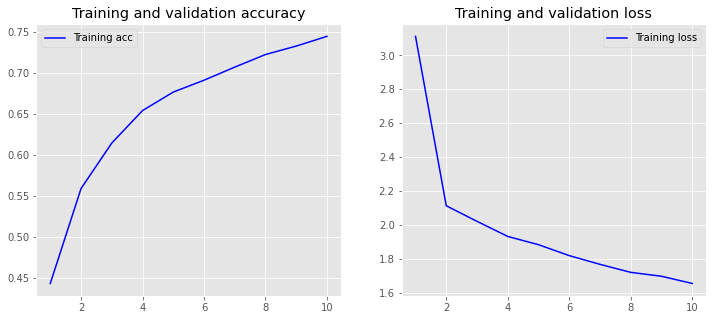

In [ ]:
plot_history(hist)

In [ ]:
metrics

[1.592871904373169, 0.7390000224113464]

In [ ]:
gBest.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 51)        1428      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 51)       204       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 51)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 51)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 22)        17974     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 22)       88        
 hNormalization)                                        

In [ ]:
print("trainable_count ; ",trainable_count)

matplotlib.use('Agg')
plt.plot(gBest_acc)
plt.xlabel("Iteration")
plt.ylabel("gBest acc")
plt.savefig(results_path + "gBest-iter-" + str(i) + ".png")
plt.close()

print('gBest architecture: ')
print(gBest)

np.save(results_path + "gBest_inter_" + str(i) + "_acc_history.npy", gBest_acc)

np.save(results_path + "gBest_iter_" + str(i) + "_test_acc_history.npy", gBest_test_acc)

trainable_count ;  21795029
gBest architecture: 
conv | conv | conv | conv | conv | conv | conv | conv | conv | fc | fc | 


In [ ]:
#  saving the model 
# from google.colab import drive
# drive.mount('/content/gdrive')
# gBest.model.save(path)


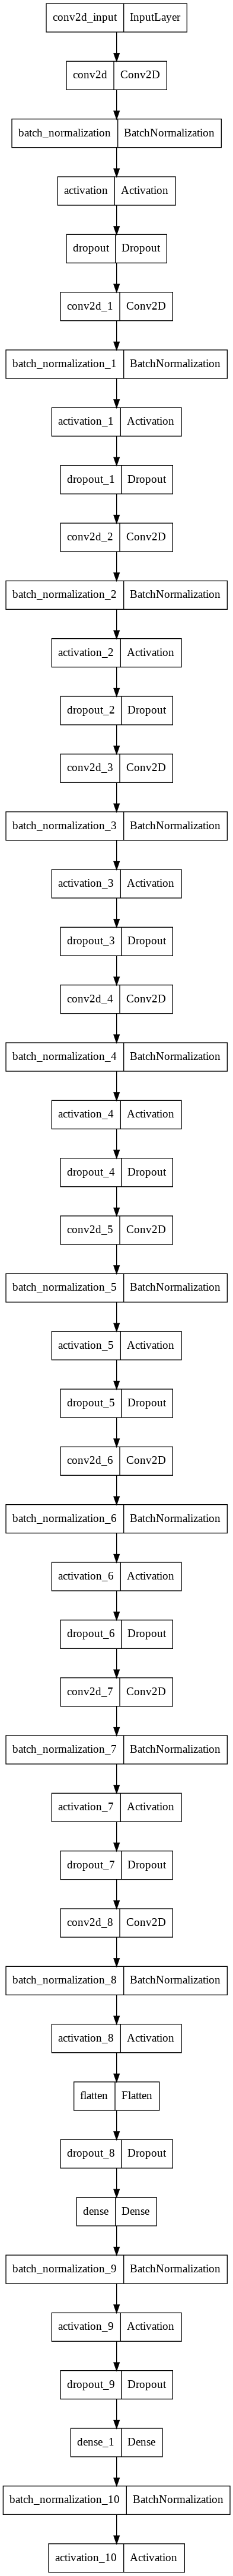

In [ ]:
plot_model(gBest.model)